Filtering the dataset based on covid +ve and -ve

In [68]:
import pandas as pd
import os
import numpy as np

# datapath1='covid-chestxray-dataset-master'
# dataset_path='dataset'

# categories=os.listdir(dataset_path)
# print(categories)

# dataset=pd.read_csv(os.path.join(datapath1,'metadata.csv'))
# findings=dataset['finding']
# image_names=dataset['filename']

dataset_path='Cutout Files'

categories=os.listdir(dataset_path)
print(categories)

['galaxy', 'star']


In [69]:
# positives_index=np.concatenate((np.where(findings=='Pneumonia/Viral/COVID-19')[0],np.where(findings=='Pneumonia/Viral/SARS')[0]))
# positive_image_names=image_names[positives_index]

In [70]:
import cv2

# for positive_image_name in positive_image_names:
#     image=cv2.imread(os.path.join(datapath1,'images',positive_image_name))
#     try:
#         cv2.imwrite(os.path.join(dataset_path,categories[1],positive_image_name),image)
#     except Exception as e:
#         print(e)

In [71]:
# positive_image_names.shape

In [72]:
# datapath2='562468_1022626_bundle_archive'

# dataset=pd.read_csv(os.path.join(datapath2,'Chest_xray_Corona_Metadata.csv'))
# findings=dataset['Label']
# image_names=dataset['X_ray_image_name']

In [73]:
# negative_index=np.where(findings=='Normal')[0]

In [74]:
# negative_image_names=image_names[negative_index]

In [75]:
# for negative_image_name in negative_image_names:
#     image=cv2.imread(os.path.join(datapath2,'images',negative_image_name))
#     try:
#         cv2.imwrite(os.path.join(dataset_path,categories[0],negative_image_name),image)
#     except Exception as e:
#         print(e)


In [76]:
# negative_image_names.shape

# Pre-processing

In [77]:
import cv2,os

data_path='Cutout Files'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'galaxy': 0, 'star': 1}
['galaxy', 'star']
[0, 1]


In [78]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [79]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [80]:
np.save('data',data)
np.save('target',new_target)

# training the CNN

In [81]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [82]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):
    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

#This is the first convolution of 64

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#This is the first convolution of 32
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the results
model.add(Flatten())
model.add(Dropout(0.5))

# 128 neuron hidden layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# 64 neuron hidden layer
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

#2 output neuron. It will contain +ve and -ve
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 100, 100, 384)     11008     
                                                                 
 conv2d_18 (Conv2D)          (None, 98, 98, 64)        221248    
                                                                 
 activation_6 (Activation)   (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 activation_7 (Activation)   (None, 47, 47, 32)        0         
                                                      

In [83]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [84]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=15,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/15
80/80 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7498

INFO:tensorflow:Assets written to: model-001.model\assets


INFO:tensorflow:Assets written to: model-001.model\assets


80/80 [==============================] - 434s 5s/step - loss: 0.5904 - accuracy: 0.7498 - val_loss: 0.5727 - val_accuracy: 0.7680
Epoch 2/15
80/80 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7627

INFO:tensorflow:Assets written to: model-002.model\assets


INFO:tensorflow:Assets written to: model-002.model\assets


80/80 [==============================] - 384s 5s/step - loss: 0.5687 - accuracy: 0.7627 - val_loss: 0.5537 - val_accuracy: 0.7680
Epoch 3/15
80/80 [==============================] - 378s 5s/step - loss: 0.5665 - accuracy: 0.7627 - val_loss: 0.5547 - val_accuracy: 0.7680
Epoch 4/15
80/80 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7627

INFO:tensorflow:Assets written to: model-004.model\assets


INFO:tensorflow:Assets written to: model-004.model\assets


80/80 [==============================] - 394s 5s/step - loss: 0.5579 - accuracy: 0.7627 - val_loss: 0.5472 - val_accuracy: 0.7680
Epoch 5/15
80/80 [==============================] - 371s 5s/step - loss: 0.5525 - accuracy: 0.7627 - val_loss: 0.5603 - val_accuracy: 0.7680
Epoch 6/15
80/80 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7627

INFO:tensorflow:Assets written to: model-006.model\assets


INFO:tensorflow:Assets written to: model-006.model\assets


80/80 [==============================] - 378s 5s/step - loss: 0.5571 - accuracy: 0.7627 - val_loss: 0.5454 - val_accuracy: 0.7680
Epoch 7/15
80/80 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7627

INFO:tensorflow:Assets written to: model-007.model\assets


INFO:tensorflow:Assets written to: model-007.model\assets


80/80 [==============================] - 375s 5s/step - loss: 0.5507 - accuracy: 0.7627 - val_loss: 0.5417 - val_accuracy: 0.7680
Epoch 8/15
80/80 [==============================] - 374s 5s/step - loss: 0.5522 - accuracy: 0.7627 - val_loss: 0.5423 - val_accuracy: 0.7680
Epoch 9/15
80/80 [==============================] - 370s 5s/step - loss: 0.5502 - accuracy: 0.7627 - val_loss: 0.5417 - val_accuracy: 0.7680
Epoch 10/15
80/80 [==============================] - 371s 5s/step - loss: 0.5496 - accuracy: 0.7627 - val_loss: 0.5418 - val_accuracy: 0.7680
Epoch 11/15
80/80 [==============================] - 369s 5s/step - loss: 0.5501 - accuracy: 0.7627 - val_loss: 0.5419 - val_accuracy: 0.7680
Epoch 12/15
80/80 [==============================] - 371s 5s/step - loss: 0.5501 - accuracy: 0.7627 - val_loss: 0.5417 - val_accuracy: 0.7680
Epoch 13/15
80/80 [==============================] - 371s 5s/step - loss: 0.5493 - accuracy: 0.7627 - val_loss: 0.5431 - val_accuracy: 0.7680
Epoch 14/15
80/80 [=

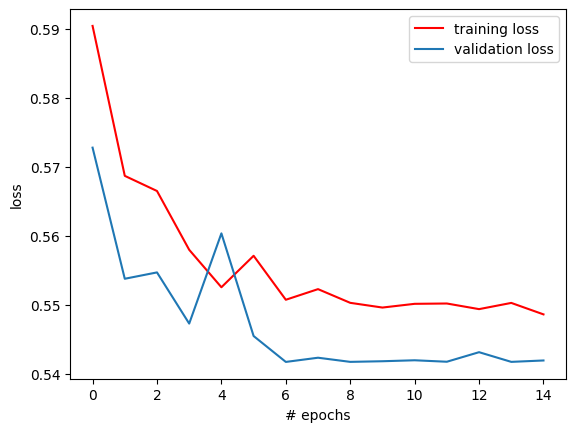

In [85]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()